# Task 1

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
import numpy as np

In [87]:
with open(r"/home/uncookie/Documents/datasets/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [88]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:][:2000]

In [89]:
corpus = cut_data(text)

In [90]:
torch.cuda.is_available()

True

In [91]:
def whitespace_tokenizer(corpus):
    vocab = set(" ".join(corpus).split())
    word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    def tokenize(text):
        return [word2idx.get(word, 0) for word in text.split()]
    
    return tokenize, word2idx, idx2word

In [92]:
whitespace_tokenize, word2idx, idx2word = whitespace_tokenizer(corpus)

In [93]:
print("Whitespace:", [whitespace_tokenize(text) for text in corpus])

Whitespace: [[1533, 13211, 7684, 1708, 9990, 5025, 9112, 5269, 7821, 11165, 14230, 12342, 10685], [9651, 319, 1299, 5288, 4025, 1980, 339, 11395, 11337, 14309, 3593, 169, 11419, 1487, 11991, 6054, 169, 12566, 7217, 13937, 13448], [14192, 8003, 5612, 14230, 159, 2606, 954, 10031, 2531, 4991, 9018, 5612, 12393, 4478, 7684, 7194, 12076, 7818, 3224, 11577, 13409, 126, 7684, 5612, 12188], [14192, 3199, 12258, 10889, 8724, 5612, 12245, 12121, 9085, 1513, 13409, 7344, 8286, 9667, 12875, 12600, 11055, 12029, 369, 11940, 159, 892, 10678, 13409, 6311, 13545, 3084, 579, 10288, 9096, 3199, 1195, 169, 1794, 13409, 2907, 2840, 4670, 8069, 1593, 869, 12976, 3082, 1940, 4319, 5254, 14192, 6341, 11588], [10144, 10377, 460, 2226, 2730, 4904, 1980, 186, 2514, 10377, 7050, 11069, 5534, 2187, 12957, 7684, 12293, 8308, 5122, 13409, 6846, 8993, 11634, 11489, 14487, 4472, 224, 4386, 4319, 9337, 3887, 6399], [13999, 6676, 9193, 3973, 5229, 11913, 14192, 1690, 159, 11397, 5144, 14192, 1690, 7670, 12050, 9193, 3

In [94]:
class TextDataset(Dataset):
    def __init__(self, tokenized_data, seq_length):
        self.data = [item for seq in tokenized_data for item in seq]
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long),
                torch.tensor(self.data[idx+1:idx+self.seq_length+1], dtype=torch.long))
    
seq_length = 5
dataset_whitespace = TextDataset([whitespace_tokenize(text) for text in corpus], seq_length)

In [95]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

In [96]:
def train_model(model, dataset, optimizer, criterion, epochs=5, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader)}")

In [97]:
embedding_dim = 50
hidden_dim = 128
vocab_size = len(word2idx) + 1  

model_whitespace = LSTMModel(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model_whitespace.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_model(model_whitespace, dataset_whitespace, optimizer, criterion, epochs=5, batch_size=32)

Epoch 1/5, Loss: 5.560907360885354
Epoch 2/5, Loss: 1.895994236813831
Epoch 3/5, Loss: 1.2837038558738887
Epoch 4/5, Loss: 1.131084363629353
Epoch 5/5, Loss: 1.070374810267836


In [98]:
def generate_text(model, start_seq, idx2word, seq_length, num_words=20):
    model.eval()
    result = start_seq
    input_seq = torch.tensor(start_seq, dtype=torch.long).unsqueeze(0)
    hidden = None
    for _ in range(num_words):
        output, hidden = model(input_seq, hidden)
        next_word = torch.argmax(output[:, -1, :], dim=-1).item()
        result.append(next_word)
        input_seq = torch.tensor([result[-seq_length:]], dtype=torch.long)
    return " ".join([idx2word.get(idx, "<unk>") for idx in result])

start_seq = [word2idx["Зачем"], word2idx["нужно"]]
generated_text = generate_text(model_whitespace, start_seq, idx2word, seq_length)
print("Generated text:", generated_text)

Generated text: Зачем нужно сделать, чтобы секс стал безопасным?- Занимайся им еще нужно хочется ли объяснить поведение женщины?- Можно. Но это объяснение никто не


In [ ]:
def bpe_tokenizer(corpus):
    tokenizer = Tokenizer(models.BPE())
    trainer = trainers.BpeTrainer(special_tokens=["<unk>", "<pad>"])
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.train_from_iterator(corpus, trainer)
    tokenizer.enable_padding(pad_id=0, pad_token="<pad>")
    return tokenizer

bpe = bpe_tokenizer(corpus)

bpe_corpus = [bpe.encode(text).ids for text in corpus]
print("BPE corpus:", bpe_corpus)

bpe_vocab_size = len(bpe.get_vocab())
print("BPE vocabulary size:", bpe_vocab_size)




BPE сorpus: [[792, 6907, 6, 156, 2045, 3, 108, 21, 1556, 3, 15940, 13457, 16352, 18862, 8, 356, 206, 18458, 6, 2371, 2], [14999, 1598, 6, 304, 18435, 535, 6, 124, 2206, 1224, 721, 1193, 18019, 101, 921, 581, 8, 315, 753, 101, 165, 5783, 1082, 3746, 2], [7, 2382, 6, 198, 206, 336, 13408, 376, 3398, 168, 283, 189, 92, 2747, 6, 198, 10067, 206, 6, 156, 172, 1704, 15687, 189, 16585, 10238, 127, 4792, 6, 156, 198, 13311, 21, 106, 219], [7, 65, 444, 4184, 3962, 6, 198, 140, 1170, 13410, 168, 15182, 127, 4499, 6, 2829, 6, 299, 8, 769, 12693, 13404, 131, 16234, 10462, 336, 136, 736, 127, 14844, 189, 326, 6, 262, 112, 1499, 1332, 189, 65, 621, 101, 12836, 127, 1067, 8, 83, 385, 6751, 7073, 414, 18257, 18812, 19, 222, 2361, 4752, 7, 14599, 17889, 8], [18626, 110, 4010, 8, 2704, 247, 3350, 6, 124, 6970, 7076, 110, 1111, 6, 15968, 4828, 6, 11466, 6, 4399, 6, 156, 636, 407, 489, 127, 584, 6, 3914, 2867, 4195, 6, 4535, 8, 67, 4780, 6, 18317, 2361, 311, 6972, 12023, 8], [312, 332, 7268, 2308, 107,

In [100]:
bpe_seq_length = 5  
bpe_dataset = TextDataset(bpe_corpus, bpe_seq_length)

In [101]:
bpe_model = LSTMModel(bpe_vocab_size, embedding_dim, hidden_dim)
bpe_optimizer = torch.optim.Adam(bpe_model.parameters(), lr=0.01)
bpe_criterion = nn.CrossEntropyLoss()

In [103]:
train_model(bpe_model, bpe_dataset, bpe_optimizer, bpe_criterion, epochs=5, batch_size=32)

Epoch 1/5, Loss: 3.1359539755918
Epoch 2/5, Loss: 2.015075623942936
Epoch 3/5, Loss: 1.685544222477884
Epoch 4/5, Loss: 1.5454631342064218
Epoch 5/5, Loss: 1.463717527162373


In [107]:
def decode_bpe(tokens, tokenizer):
    return tokenizer.decode(tokens, skip_special_tokens=True)

def generate_bpe_text(model, start_tokens, tokenizer, seq_length, num_words=20):
    model.eval()
    result = start_tokens
    input_seq = torch.tensor(start_tokens, dtype=torch.long).unsqueeze(0)
    hidden = None
    for _ in range(num_words):
        output, hidden = model(input_seq, hidden)
        next_token = torch.argmax(output[:, -1, :], dim=-1).item()
        result.append(next_token)
        input_seq = torch.tensor([result[-seq_length:]], dtype=torch.long)
    return decode_bpe(result, tokenizer)

start_tokens = bpe.encode("Президент").ids
generated_bpe_text = generate_bpe_text(bpe_model, start_tokens, bpe, bpe_seq_length)
print("Generated BPE text:", generated_bpe_text)

Generated BPE text: Президент делает все , чтобы бы не потому как евреи всегда остаются без медалей . Ничем не могу уделить вам .-


Whitespace-токенайзер и BPE-токенайзер значительно различаются по подходам и области применения. Whitespace-токенайзер разбивает текст на слова, используя пробелы в качестве разделителей. Это простой и интуитивно понятный метод, который легко интерпретировать и реализовать. Однако он имеет существенные ограничения: плохо работает с языками, где слова не разделяются пробелами (например, китайский или японский), не способен обработать редкие или новые слова и приводит к значительному увеличению размера словаря, поскольку каждое слово представлено как отдельный токен.

BPE-токенайзер, напротив, разбивает текст на подслова, начиная с отдельных символов и постепенно объединяя самые часто встречающиеся пары токенов. Это обеспечивает большую гибкость и лучшее обобщение, так как позволяет модели эффективно обрабатывать редкие или новые слова, разбивая их на подслова. Размер словаря у BPE существенно меньше, что делает его более эффективным для задач с большими корпусами текста. Кроме того, BPE подходит для языков без пробелов, что делает его универсальным решением. Однако его настройка и обучение сложнее, а полученные токены труднее интерпретировать.

# Task 1.1

In [120]:
import numpy as np
from collections import Counter
import re

In [121]:
with open(r"/home/uncookie/Documents/datasets/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [122]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [123]:
corpus = cut_data(text)

In [124]:
class CustomTokenizer:
    def __init__(self, vocab_size=None):
        self.vocab_size = vocab_size
        self.token_to_id = {}
        self.id_to_token = {}
    
    def preprocess(self, text): 
        return text.lower()
    
    def tokenize(self, text):
        return text.split()
    
    def fit(self, corpus):
        all_tokens = []
        for text in corpus:
            processed_text = self.preprocess(text)
            tokens = self.tokenize(processed_text)
            all_tokens.extend(tokens)
        
        token_counts = Counter(all_tokens)
        
        most_common_tokens = token_counts.most_common(self.vocab_size)
        vocab = [token for token, _ in most_common_tokens]
        
        self.token_to_id = {token: idx for idx, token in enumerate(vocab)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
    
    def encode(self, text):
        processed_text = self.preprocess(text)
        tokens = self.tokenize(processed_text)
        return [self.token_to_id.get(token, -1) for token in tokens]  
    
    def decode(self, token_ids):
        return " ".join([self.id_to_token.get(idx, "<unk>") for idx in token_ids])


In [125]:
tokenizer = CustomTokenizer(vocab_size=10000) 
tokenizer.fit(corpus)

In [126]:
text = "Тут могла быть ваша реклама !!!"
encoded = tokenizer.encode(text)
decoded = tokenizer.decode(encoded)

In [127]:
print("Исходный текст:", text)
print("Токены:", tokenizer.tokenize(tokenizer.preprocess(text)))
print("Закодированный текст:", encoded)
print("Декодированный текст:", decoded)
print("Словарь токенов:", tokenizer.token_to_id)

Исходный текст: Тут могла быть ваша реклама !!!
Токены: ['тут', 'могла', 'быть', 'ваша', 'реклама', '!!!']
Закодированный текст: [101, 1150, 95, 289, 1725, -1]
Декодированный текст: тут могла быть ваша реклама <unk>
Словарь токенов: {'-': 0, 'в': 1, 'и': 2, 'не': 3, 'на': 4, 'а': 5, 'что': 6, 'я': 7, 'с': 8, 'у': 9, 'это': 10, 'ты': 11, 'как': 12, 'по': 13, 'вы': 14, 'если': 15, 'за': 16, 'когда': 17, 'все': 18, 'меня': 19, 'к': 20, 'он': 21, 'но': 22, 'так': 23, 'из': 24, 'мне': 25, 'от': 26, 'только': 27, 'чтобы': 28, 'же': 29, 'то': 30, 'бы': 31, 'его': 32, 'уже': 33, 'для': 34, 'она': 35, 'еще': 36, 'тебя': 37, 'почему': 38, 'вас': 39, 'да': 40, 'вот': 41, 'мы': 42, 'чем': 43, 'они': 44, 'ну': 45, 'о': 46, 'кто': 47, 'тебе': 48, 'есть': 49, 'до': 50, 'ее': 51, 'или': 52, 'после': 53, 'нет,': 54, 'можно': 55, 'вам': 56, 'жена': 57, 'очень': 58, 'два': 59, 'их': 60, 'нас': 61, 'один': 62, 'просто': 63, 'там': 64, 'будет': 65, 'сегодня': 66, 'ну,': 67, 'может': 68, 'где': 69, 'теперь'

# Task 2

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def generate_data(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = [np.sin(x + np.random.uniform(-0.1, 0.1)) for _ in range(num_samples)]
    data = np.array(data)
    return data[:, :-1], data[:, 1:]  

In [13]:
seq_length = 50  
num_samples = 1000 
hidden_size = 20  
input_size = 1 
output_size = 1  
num_epochs = 150 
learning_rate = 0.001

In [14]:
x_data, y_data = generate_data(seq_length, num_samples)
x_data = torch.tensor(x_data, dtype=torch.float32).unsqueeze(-1)  
y_data = torch.tensor(y_data, dtype=torch.float32).unsqueeze(-1)  

In [15]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)  
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)  
        self.bh = nn.Parameter(torch.zeros(hidden_size)) 
        self.Why = nn.Parameter(torch.randn(hidden_size, output_size) * 0.01) 
        self.by = nn.Parameter(torch.zeros(output_size)) 


    def forward(self, x, h_prev):
        h_next = torch.tanh(x @ self.Wxh + h_prev @ self.Whh + self.bh)  
        y = h_next @ self.Why + self.by  
        return y, h_next


In [16]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = SimpleRNN(input_size, hidden_size, output_size)


    def forward(self, x):
        h = torch.zeros(x.size(0), self.rnn.hidden_size)  
        outputs = []
        for t in range(x.size(1)):
            y, h = self.rnn(x[:, t, :], h)
            outputs.append(y.unsqueeze(1))
        return torch.cat(outputs, dim=1)

In [17]:
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
loss_history = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_data)
    loss = criterion(outputs, y_data)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [50/150], Loss: 0.2531
Epoch [100/150], Loss: 0.0730
Epoch [150/150], Loss: 0.0379


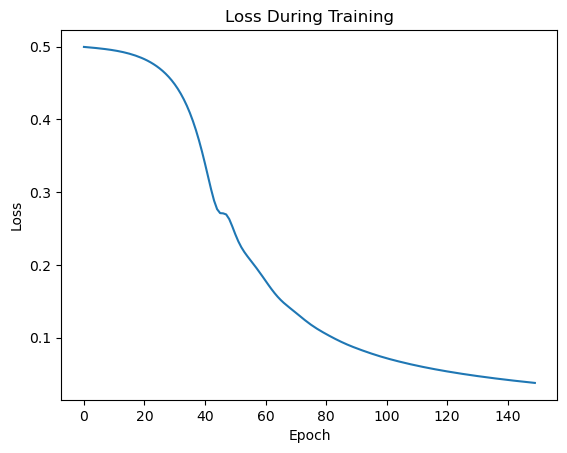

In [ ]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.show()

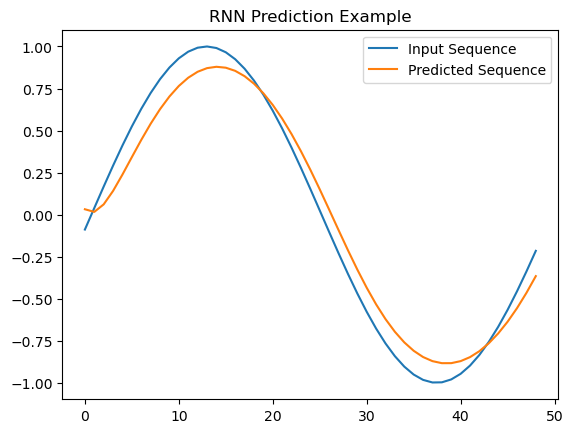

In [ ]:
model.eval()
test_sample = x_data[0:1]
with torch.no_grad():
    prediction = model(test_sample)

plt.plot(test_sample.squeeze().numpy(), label="Input sequence")
plt.plot(prediction.squeeze().numpy(), label="Predicted sequence")
plt.legend()
plt.title("Result")
plt.show()

# Task 3

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [24]:
def generate_data(num_samples=1000, sequence_length=10, num_classes=2):
    X = np.random.randn(num_samples, sequence_length, 1)  
    y = (X.mean(axis=1) > 0).astype(int).flatten()  
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [34]:
generate_data(1)

(tensor([[[-0.7809],
          [ 0.1357],
          [-3.1089],
          [ 0.8153],
          [-0.5784],
          [-0.3068],
          [ 1.1563],
          [-0.1138],
          [ 2.1582],
          [ 0.7130]]]),
 tensor([1]))

In [25]:
num_samples = 50000
sequence_length = 10
input_size = 1
hidden_size = 32
num_classes = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [26]:
X, y = generate_data(num_samples=num_samples, sequence_length=sequence_length, num_classes=num_classes)
data_loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)

In [27]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)  
        out = out[:, -1, :] 
        out = self.fc(out)   
        return out


In [28]:
model = RNNClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [29]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(data_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.1510
Epoch [2/10], Loss: 0.1048
Epoch [3/10], Loss: 0.0897
Epoch [4/10], Loss: 0.0209
Epoch [5/10], Loss: 0.0523
Epoch [6/10], Loss: 0.0144
Epoch [7/10], Loss: 0.0140
Epoch [8/10], Loss: 0.0021
Epoch [9/10], Loss: 0.0815
Epoch [10/10], Loss: 0.0008


In [31]:
with torch.no_grad():
    X_test, y_test = generate_data(num_samples=1000, sequence_length=sequence_length)
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9720
